In [147]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [148]:
def read_benchstat_csv(infile):
    df = pd.read_csv(infile)
    df.columns=['_name', 'time', '_time_sd']

    name_parts = df['_name'].str.extract(r'(?P<name>[^/]+)/size=(?P<size>\d+)-(?P<cpus>\d+)')
    name_parts = name_parts.astype({'size': 'int32', 'cpus': 'int32'})

    time_sd = df['_time_sd'].str.extract(r'(\d+)%', expand=False).astype('float64')
    time_sd = time_sd / 100 * df.time
    time_sd.name = 'time_sd'
    
    df = pd.concat([name_parts, df.time, time_sd], axis=1)
    return df.set_index(['name', 'size'])

In [149]:
from glob import glob
glob('./*.csv')

['./03c422e.csv', './d6683f3.csv', './2521f4e.csv']

In [156]:
df = read_benchstat_csv('2521f4e.csv')
df

cpus       time      time_sd
name       size                               
Fork       64        8   627105.0   344907.750
           256       8   716765.0   229364.800
           1024      8   451854.0   347927.580
           4096      8   493873.0   311139.990
           16384     8   879049.0   140647.840
SetCursor  64        8    10670.3     1173.733
           256       8    49541.6     7926.656
           1024      8   233863.0    18709.040
           4096      8   815895.0    65271.600
           16384     8  4600720.0   276043.200
InsertChar 64        8  5408190.0  1027556.100
           256       8  4864100.0   632333.000
           1024      8  4576550.0   183062.000
           4096      8  5288150.0   370170.500
           16384     8  9936670.0   695566.900

In [151]:
from matplotlib.ticker import EngFormatter

def plot_time_vs_size(size, time_sec, time_sd_sec):
    fig, ax = plt.subplots()
    ax.grid(True, which='both')

    # x axis configuration
    logx_min, logx_max = 5, 15
    logx_num = logx_max - logx_min + 1
    ax.set_xscale('log', basex=2)
    ax.set_xticks(np.logspace(logx_min, logx_max, num=logx_num, base=2))
    ax.set_xlabel('List size')

    # y axis configuration
    ax.set_yscale('log')
    y_formatter = EngFormatter(unit='s')
    ax.yaxis.set_minor_formatter(y_formatter)
    ax.yaxis.set_major_formatter(y_formatter)
    ax.set_ylabel('Time per operation')

    plt.errorbar(size, time_sec, fmt='o', yerr=time_sd_sec)
    return ax

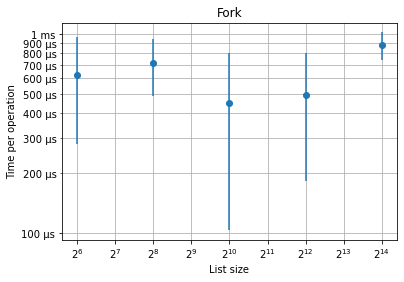

In [157]:
# Analysing fork operation
fork = df.xs('Fork')

ax = plot_time_vs_size(fork.index, fork.time * 1e-9, fork.time_sd * 1e-9)
_ = ax.set_title('Fork')

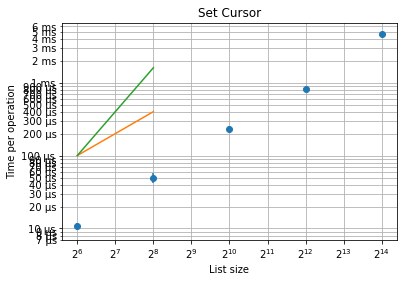

In [158]:
# Analysing set cursor operation
set_cursor = df.xs('SetCursor')

xs = set_cursor.index
ax = plot_time_vs_size(xs, set_cursor.time * 1e-9, set_cursor.time_sd * 1e-9)
ax.set_title('Set Cursor')

demo = np.logspace(6, 8, num=10, base=2)
ax.plot(demo, 100e-6 * demo/2**6)      # O(n)
ax.plot(demo, 100e-6 * (demo/2**6)**2) # O(n^2)

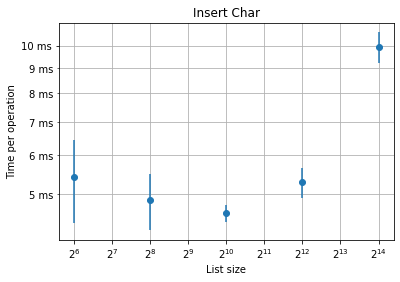

In [159]:
# Analysing insert char alone
_char = df.xs('InsertChar')

ax = plot_time_vs_size(_char.index, _char.time * 1e-9, _char.time_sd * 1e-9)
_ = ax.set_title('Insert Char')

/home/bkim/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


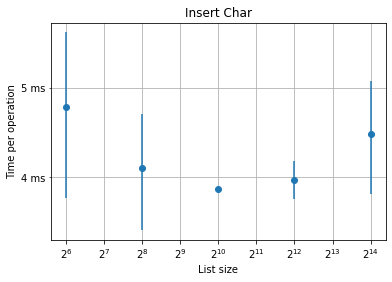

In [160]:
# Analysing insert char operation
_char = df.xs('InsertChar')

# insert_char operation is measured together with fork and set_cursor, so we need to remove their contributions.
char_time = _char.time - set_cursor.time - fork.time
char_time_sd = np.sqrt(_char.time_sd**2 - set_cursor.time_sd**2 - fork.time_sd**2)

ax = plot_time_vs_size(_char.index, char_time * 1e-9, char_time_sd * 1e-9)
_ = ax.set_title('Insert Char')